In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
import math

from scipy import stats

sns.set_theme()

In [38]:
def read_input(file_path, two_d=False):
    # by default a row of numbers in loaded as a 1D vector
    data = np.loadtxt(file_path)
    if two_d:
        if data.ndim == 1:
            data = data.reshape((1, -1))
    return data

In [39]:
poly_path = "PA-1-data-text/polydata_data_"
X_sample = read_input(f"{poly_path}sampx.txt", two_d=True)
y_sample = read_input(f"{poly_path}sampy.txt")
X_poly = read_input(f"{poly_path}polyx.txt", two_d=True)
y_poly = read_input(f"{poly_path}polyy.txt")

## Part 1: Polynomial function

For this part, we first define a base class for all regression models.

In [5]:
class Regression:
    """Abstract base class for all regression models.

    Suppose a scalar function f(x, θ) with an input x ∈ R^d and an unknown parameter
    θ ∈ R^D has the form
    
        f(x, θ) = ϕ(x)^T θ,
    
    where ϕ: R^d → R^D is a known feature transformation. Given a dataset of n pairs
    (x_i, y_i) of input and *noisy* output, our goal is to estimate the value of the
    parameter θ and use it to predict the output of the function with a new input x*.
    For convenience, we define three variables

        y = [y_1 ... y_n]^T,    Φ = [ϕ(x_1) ... ϕ(x_n)],    X = [x_1 ... x_n].

    The API here mirrors that of a model in scikit-learn with two main methods:
    - `fit(X, y)`: estimate the parameter using the given data (training)
    - `predict(x)`: predict the output corresponds to the given input (inference)
    """

    def __init__(self):
        # a R^d -> R^D feature transformation
        self.phi = None
        self.title = None

    def fit(self, X, y):
        pass

    def predict(self, x):
        pass

### (a) Implement 5 regression algorithms

In [6]:
class LS(Regression):
    """Least Squares (LS) Regression

    This regression model aims to minimize the L2-norm of the difference between the
    given output and the output of the function, i.e.

       θ^_LS = argmin_θ ‖y - Φ^T θ‖^2
             = (ΦΦ^T)^(-1)Φy

    The prediction for input x* is then f* = ϕ(x*)^T θ^.
    """

    def __init__(self):
        self.title = f"Least Squares Regression"

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        inv = np.linalg.inv(Phi @ Phi.T)
        self.theta_hat = inv @ Phi @ y
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return Phi.T @ self.theta_hat

In [7]:
class RLS(Regression):
    """Regularized Least Squares (RLS) Regression

    This regression model aims to minimize the L2-norm of the difference between the
    real and the predicted outputs, together with the L2-norm of the parameter as a
    penalty term, i.e.,

       θ^_LS = argmin_θ ‖y - Φ^T θ‖^2 + λ‖θ‖^2
             = (ΦΦ^T + λI)^(-1)Φy

    Here, λ is a hyperparameter. The prediction for input x* is then f* = ϕ(x*)^T θ^.
    """
    def __init__(self, l=None):
        self.title = f"Regularized Least Squares Regression (λ = {l:.2f})"
        self.l = l

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D = Phi.shape[0]
        inv = np.linalg.inv(Phi @ Phi.T + self.l * np.identity(D))
        self.theta_hat = inv @ Phi @ y
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return Phi.T @ self.theta_hat

In [54]:
class LASSO(Regression):
    """LASSO Regression

    This regression model aims to minimize the L2-norm of the difference between the
    real and the predicted outputs, together with the L1-norm of the parameter as a
    penalty term, i.e.,

        θ^_LASSO = argmin_θ ‖y - Φ^T θ‖^2 + λ‖θ‖_1

    Here, λ is a hyperparameter. The prediction for input x* is then f* = ϕ(x*)^T θ^.
    This optimization problem does not have a closed form solution and requires
    quadratic programming to estimate its solution.
    """

    def __init__(self, l=None):
        self.title = f"LASSO Regression (λ = {l:.2f})"
        self.l = l

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D = Phi.shape[0]
        Phi_Phi_T = Phi @ Phi.T
        Phi_y = Phi @ y

        H = np.block([[Phi_Phi_T, -Phi_Phi_T], [-Phi_Phi_T, Phi_Phi_T]])
        f = self.l - np.block([Phi_y, -Phi_y])
        x = cp.Variable(2*D)

        # To avoid cases where H is almost positive semidefinite but has very small
        # negative eigenvalues. See https://github.com/cvxpy/cvxpy/issues/407
        H_param = cp.Parameter(shape=H.shape, value=H, PSD=True)

        objective = cp.Minimize(cp.quad_form(x, H_param) + 2 * f.T @ x)
        constraints = [x >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve()

        self.theta_hat = x.value[:D] - x.value[D:]
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return Phi.T @ self.theta_hat

In [9]:
class RR(Regression):
    """Robust Regression

    This regression model aims to minimize the L1-norm of the difference between the
    real and the predicted outputs, i.e.,

        θ^_RR = argmin_θ ‖y - Φ^T θ‖_1

    The prediction for input x* is then f* = ϕ(x*)^T θ^. This optimization problem does
    not have a closed form solution and requires linear programming to estimate its
    solution.
    """

    def __init__(self):
        self.title = f"Robust Regression"

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        D, n = Phi.shape

        A = np.block([[-Phi.T, -np.identity(n)], [Phi.T, -np.identity(n)]])
        f = np.block([np.zeros(D), np.ones(n)])
        b = np.block([-y, y])
        x = cp.Variable(D+n)

        objective = cp.Minimize(f @ x)
        constraints = [A @ x <= b]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.CLARABEL)

        self.theta_hat = x.value[:D]
        return self.theta_hat

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        return Phi.T @ self.theta_hat

In [10]:
class BR(Regression):
    """Bayesian Regression

    This regression model aims to update its prior beliefs about the parameter using
    the given data to produce the posterior distribution of the parameter. Suppose θ
    has multivariate i.i.d. Gaussian prior distribution θ ~ N(0, αI) and the observed
    outputs have Gaussian noises with constant variance added to the "true" output,
    i.e., the sampling distribution is y|x,θ ~ N(f(x,θ), σ^2). Then, the posterior is

        θ|X,y ~ N(μ^_θ, Σ^_θ^2)
        μ^_θ = σ^(-2) Σ^_θ Φy
        Σ^_θ = (α^(-1)I + σ^(-2)ΦΦ^T)^(-1)

    The predictive distribution for input x* is a Gaussian, with

        f*|X,y,x* ~ N(μ^*, σ^*^2)
        μ^* = ϕ(x*)^T μ^_θ
        σ^*^2 = ϕ(x*)^T Σ^_θ ϕ(x*)
    """

    def __init__(self, alpha=None, sigma_2=None):
        self.title = f"Bayesian Regression (α = {alpha:.2f}, σ^2 = {sigma_2:.2f})"
        self.alpha = alpha
        self.sigma_2 = sigma_2

    def fit(self, X, y):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        Phi_Phi_T = Phi @ Phi.T
        D = Phi.shape[0]

        self.Sigma_hat_theta = np.linalg.inv(np.identity(D) / self.alpha + Phi_Phi_T / self.sigma_2)
        self.mu_hat_theta = self.Sigma_hat_theta @ Phi @ y / self.sigma_2
        return self.mu_hat_theta

    def predict(self, X):
        Phi = np.apply_along_axis(self.phi, 0, np.atleast_2d(X))
        mu_hat = Phi.T @ self.mu_hat_theta
        # assuming the novel inputs are independent
        sigma_2_hat = np.diag(np.diag((Phi.T @ self.Sigma_hat_theta @ Phi)))
        rng = np.random.default_rng(seed=30)
        return stats.multivariate_normal.rvs(mean=mu_hat, cov=sigma_2_hat, random_state=rng)

### (b) Fit, predict, and plot

In [11]:
def fit_predict_plot(model):
    poly_5 = lambda x: x[0]**np.array(range(6))
    model.phi = poly_5
    result = model.fit(X_sample, y_sample)
    y_poly_predict = model.predict(X_poly)
    mse = np.square(y_poly - y_poly_predict).mean()

    df_sample = pd.DataFrame({
        'x': X_sample.reshape((-1,)),
        'y': y_sample,
        'type': ['sample' for _ in range(X_sample.size)],
    })
    df_poly = pd.DataFrame({
        'x': X_poly.reshape((-1,)),
        'y': y_poly,
        'type': ['poly' for _ in range(X_poly.size)],
    })
    df_poly_predict = pd.DataFrame({
        'x': X_poly.reshape((-1,)),
        'y': y_poly_predict,
        'type': ['poly_predict' for _ in range(X_poly.size)],
    })
    df = pd.concat([df_sample, df_poly, df_poly_predict], axis=0)

    print(model.title)
    print(f"Estimated parameter:\n{result}")
    print(f"Mean squared error: {mse}")

    plot = sns.relplot(df, x='x', y='y', hue='type')
    plot.ax.set_title(model.title)
    plot.figure.show()


Least Squares Regression
Estimated parameter:
[ 6.15769274e-01  1.10406633e+00  1.33022515e+00 -6.93228415e-01
  9.17835000e-04 -6.86117508e-01]
Mean squared error: 0.4086438835698628


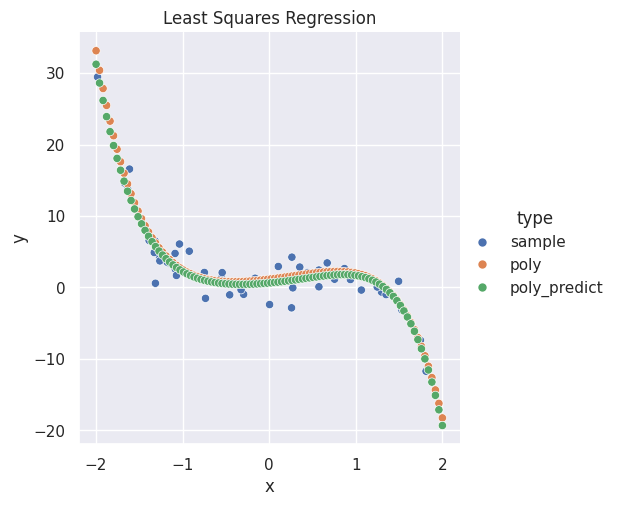

In [12]:
fit_predict_plot(LS())

Regularized Least Squares Regression (λ = 0.12)
Estimated parameter:
[ 0.62605669  1.0517      1.30848283 -0.64630659  0.00689544 -0.69530306]
Mean squared error: 0.4081686985808147


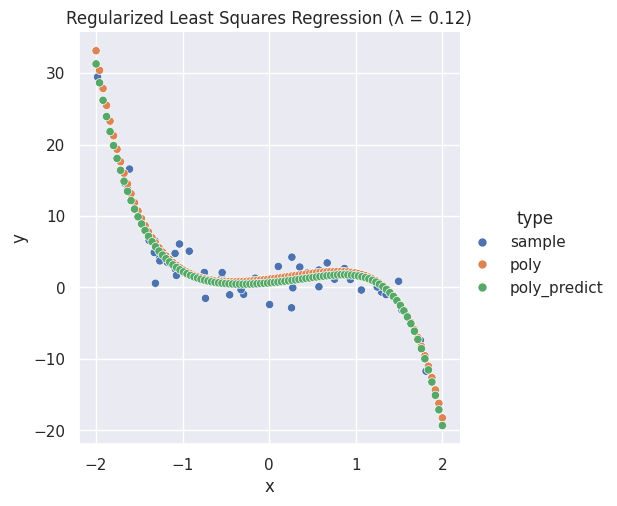

In [13]:
fit_predict_plot(RLS(l=0.12))

[[   50.            -7.13846373    59.56833439   -15.02897815
    120.96530399   -34.17811531   -50.             7.13846373
    -59.56833439    15.02897815  -120.96530399    34.17811531]
 [   -7.13846373    59.56833439   -15.02897815   120.96530399
    -34.17811531   297.39820191     7.13846373   -59.56833439
     15.02897815  -120.96530399    34.17811531  -297.39820191]
 [   59.56833439   -15.02897815   120.96530399   -34.17811531
    297.39820191   -97.89296838   -59.56833439    15.02897815
   -120.96530399    34.17811531  -297.39820191    97.89296838]
 [  -15.02897815   120.96530399   -34.17811531   297.39820191
    -97.89296838   821.47877846    15.02897815  -120.96530399
     34.17811531  -297.39820191    97.89296838  -821.47877846]
 [  120.96530399   -34.17811531   297.39820191   -97.89296838
    821.47877846  -339.00343069  -120.96530399    34.17811531
   -297.39820191    97.89296838  -821.47877846   339.00343069]
 [  -34.17811531   297.39820191   -97.89296838   821.47877846
   

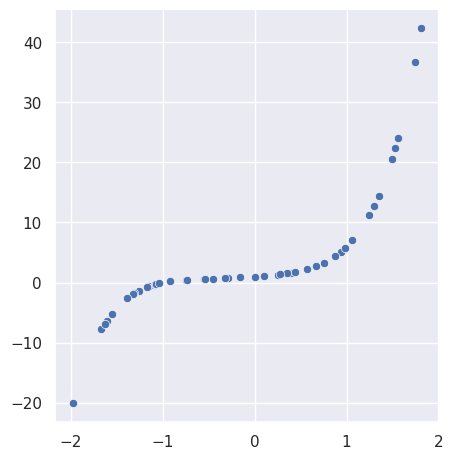

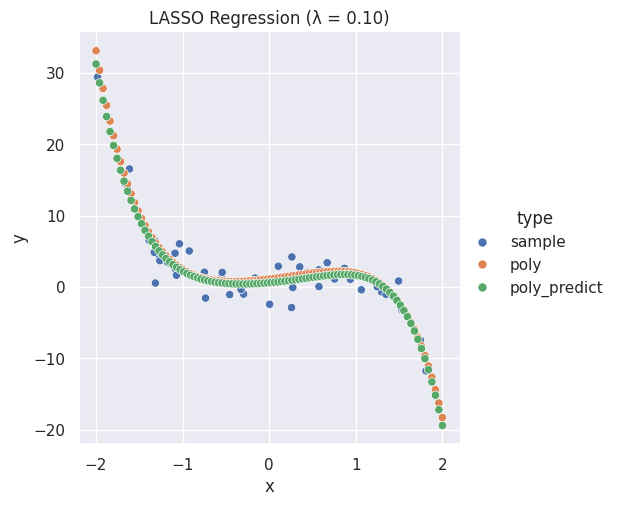

In [18]:
fit_predict_plot(LASSO(l=0.1))

Robust Regression
Estimated parameter:
[ 1.01563729  1.86713474  0.26492253 -1.70405013  0.34503288 -0.40769655]
Mean squared error: 0.7680463117516118


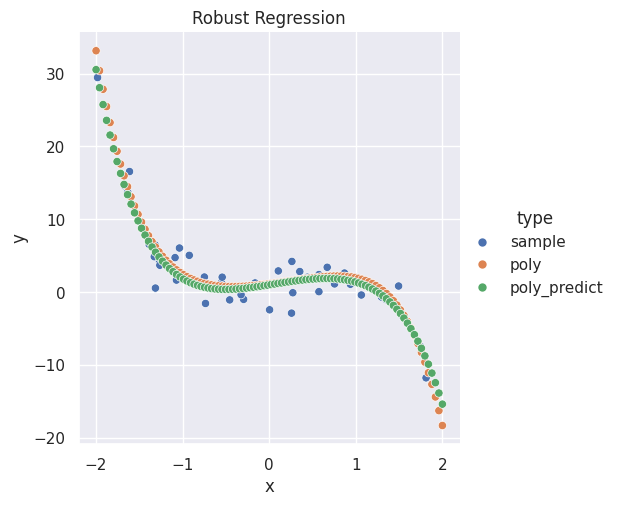

In [ ]:
fit_predict_plot(RR())

Bayesian Regression (α = 1.00, σ^2 = 0.17)
Estimated parameter:
[ 0.63012063  1.03177997  1.2996089  -0.62866253  0.0093718  -0.69872149]
Mean squared error: 0.3657160050013223


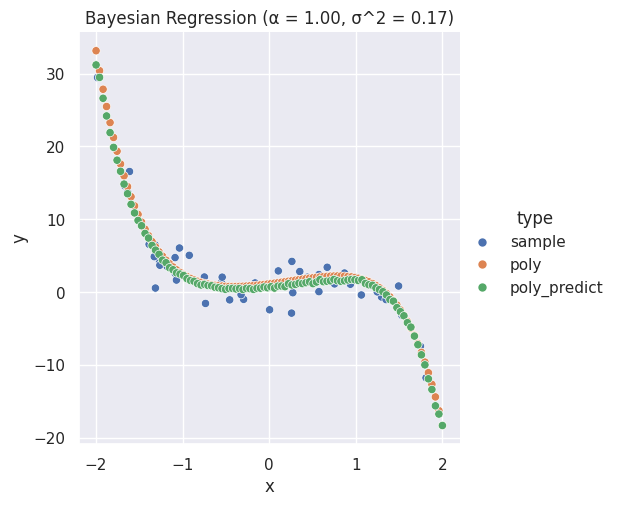

In [ ]:
fit_predict_plot(BR(alpha=1, sigma_2=0.17))

### (c) Smaller training data

/home/vscode/.local/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:226: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(DPP_ERROR_MSG)


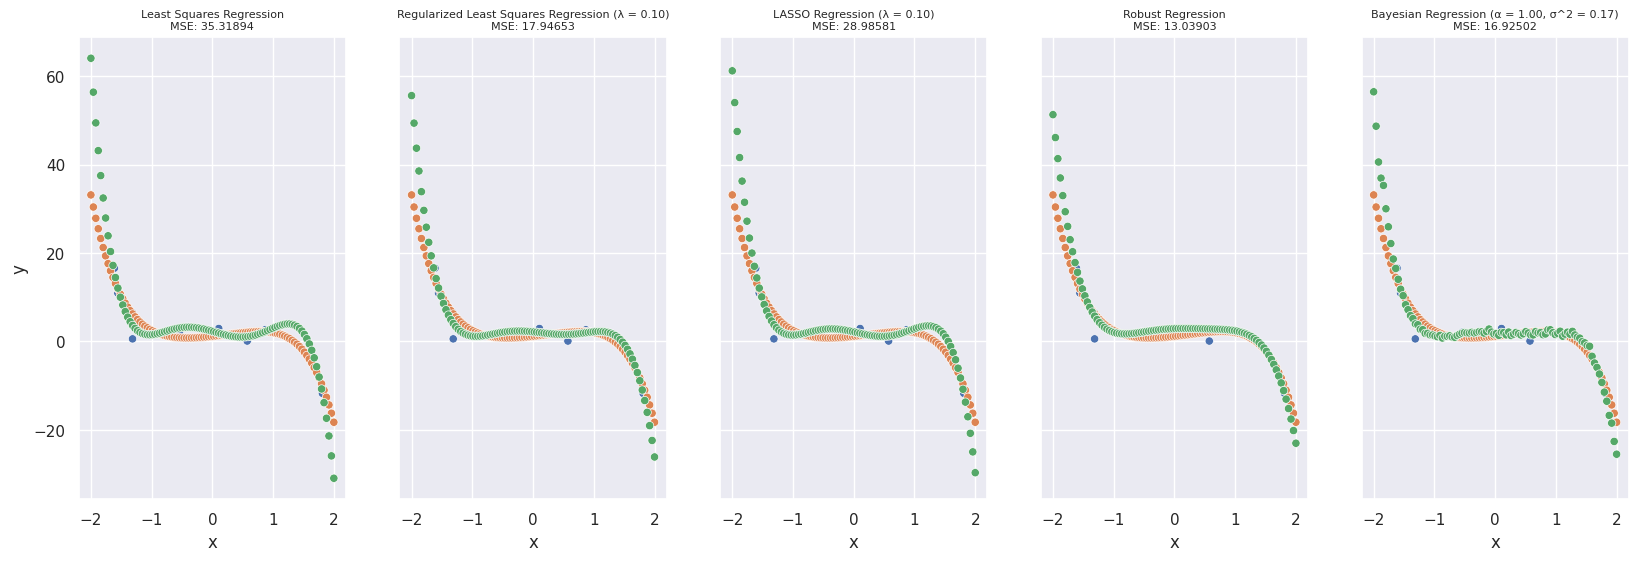

In [58]:
def fit_predict_plot_reduced_data(models, training_size=1, seed=12):
    poly_5 = lambda x: x[0]**np.arange(6)

    n = y_sample.size
    rng = np.random.default_rng(seed)
    rand_idx = rng.permutation(n)[:math.ceil(n * training_size)]
    X_sample_subset = X_sample[:, rand_idx]
    y_sample_subset = y_sample[rand_idx]


    fig, axes = plt.subplots(1, len(models), sharey=True, figsize=(len(models) * 4, 6))

    for i, model in enumerate(models):
        model.phi = poly_5
        result = model.fit(X_sample_subset, y_sample_subset)
        y_poly_predict = model.predict(X_poly)
        mse = np.square(y_poly - y_poly_predict).mean()

        df = pd.DataFrame({
            'x': X_sample_subset.reshape((-1,)),
            'y': y_sample_subset,
            'type': ['sample' for _ in range(y_sample_subset.size)],
        })
        df_poly = pd.DataFrame({
            'x': X_poly.reshape((-1,)),
            'y': y_poly,
            'type': ['poly' for _ in range(y_poly.size)],
        })
        df_poly_predict = pd.DataFrame({
            'x': X_poly.reshape((-1,)),
            'y': y_poly_predict,
            'type': ['poly_predict' for _ in range(y_poly_predict.size)],
        })
        df = pd.concat([df, df_poly, df_poly_predict], axis=0)

        sns.scatterplot(
            data=df,
            x="x",
            y="y",
            hue="type",
            legend=False,
            ax=axes[i]
        ).set_title(f"{model.title}\nMSE: {mse:.5f}", fontsize=8)

    fig.show()

models = [LS(), RLS(l=0.1), LASSO(l=0.1), RR(), BR(alpha=1, sigma_2=0.17)]
fit_predict_plot_reduced_data(models, training_size=0.2, seed=34)